In [3]:
## source: Qutiles-3head.ipynb from pytorch-temph

Calculate metrics: \
PICP: Prediction Interval Coverage Percent \
PINAW: Predictipon Interval Ner \
https://github.com/scikit-learn/scikit-learn/issues/20162 \
Expected calibration error 

Get heatmap \
Ordinal Regression (Classes with relative distances) \
Regression via Classification \
Get concrete results (or real data) 

calibration bandı ekle \
post hoc gaussian filter \

tempeature ile çıktıyı regulerize et \
trainingdeki labelları gaussianla smoothlaştır \



Long term goal: \
Get regions as predicted set (Segmentation-YOLO) 


In [4]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

In [5]:
import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None
#do not execute this if you fit auto-pytorch model

cuda is not available


In [6]:
import numpy as np
np.random.seed(42)

N = 10000
train_x = np.random.normal(0,1,(N,))
x = 3*train_x+1 # N(1,9)

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

# y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

y1 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10
x1 = train_x
y2 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 20
x2 = train_x

# y = np.concatenate((y1, y2))
# x = np.concatenate((x1, x2))
# train_x = np.concatenate((x1, x2))

y = y1
x = x1
train_x = x1

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [7]:
y.shape

(10000,)

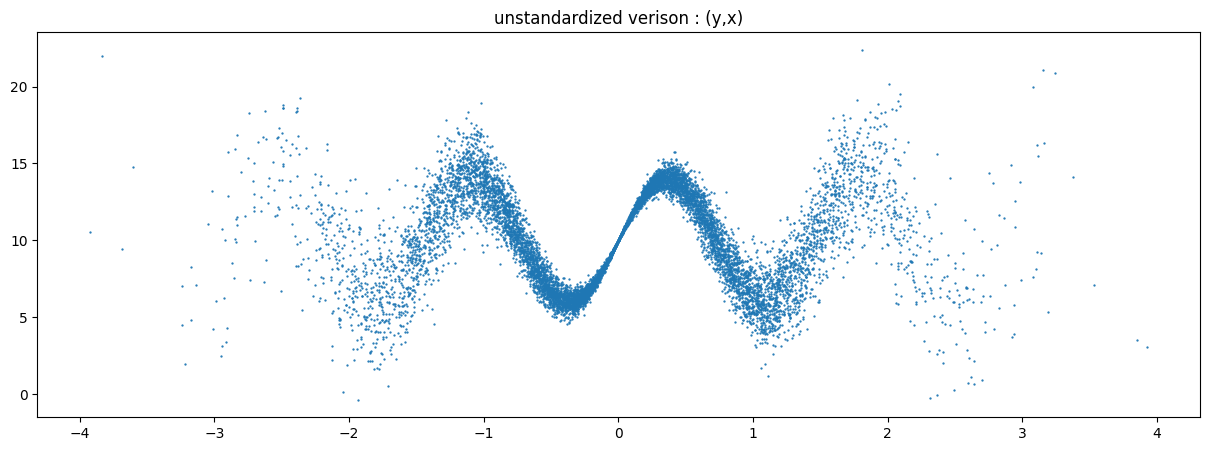

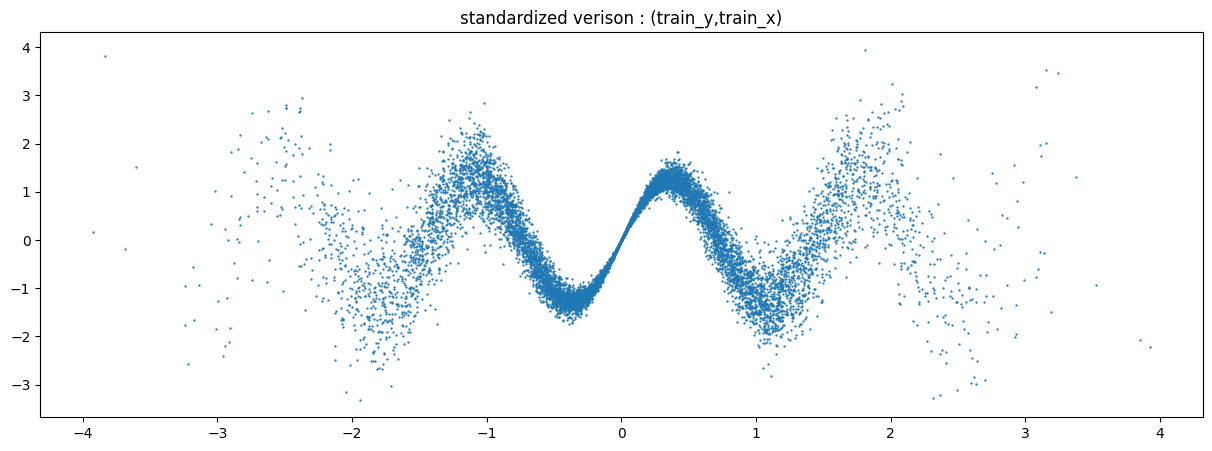

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

bin_edges =  (46,)


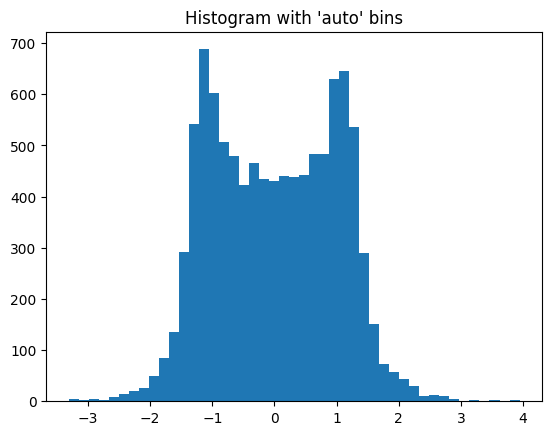

In [9]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')

hist, bin_edges, _ = plt.hist(train_y, bins='auto')  # arguments are passed to np.histogram

print("bin_edges = ", bin_edges.shape)


class_digits = np.digitize(train_y, bin_edges) # Get the class of each point using histogram bins

no_of_classes = bin_edges.shape[0]+1
one_hots = np.zeros((train_y.size, no_of_classes))
one_hots[np.arange(train_y.size), class_digits] = 1

plt.title("Histogram with 'auto' bins")
plt.show()

# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_scalar = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()
# normalize 
train_y_scalar =( train_y_scalar - train_y_scalar.mean()) / train_y_scalar.std()



train_y_tr = torch.from_numpy(one_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()

In [52]:
class dce_loss(torch.nn.Module):
    def __init__(self, n_classes,feat_dim,init_weight=True):
   
        super(dce_loss, self).__init__()
        self.n_classes=n_classes
        self.feat_dim=feat_dim
        self.centers=nn.Parameter((torch.rand(self.feat_dim,self.n_classes).to(device)* 6)-3 ,requires_grad=False)
        # if init_weight:
        #     self.__init_weight()

    # def __init_weight(self):
    #     nn.init.kaiming_normal_(self.centers)

     
    def forward(self, x):
   
        features_square=torch.sum(torch.pow(x,2),1, keepdim=True)
        centers_square=torch.sum(torch.pow(self.centers,2),0, keepdim=True)
        features_into_centers=2*torch.matmul(x, (self.centers))
        dist=features_square+centers_square-features_into_centers

        return self.centers, -dist

def regularization(features, centers, labels):
        distance=(features-torch.t(centers)[labels])

        distance=torch.sum(torch.pow(distance,2),1, keepdim=True)

        distance=(torch.sum(distance, 0, keepdim=True))/features.shape[0]

        return distance

In [53]:
class QClassifier(torch.nn.Module):
    def __init__(self, in_size=1, proto_num=20):
        super(QClassifier,self).__init__()
        self.in_size = in_size
        self.out_size = 1

        self.proto_scale = 2 
        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            # torch.nn.Dropout(p=0.9),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, self.out_size)
            )
        
        self.dce = dce_loss(n_classes=proto_num,feat_dim=self.out_size)
        

    def forward(self,x):
        x_f = self.net(x)
        centers,x = self.dce(x_f)
        output = torch.nn.functional.log_softmax(x * self.proto_scale, dim=1)
        return x_f,centers,x,output
    

In [54]:
train_x_tr = train_x_tr.to(device)
train_y_tr = train_y_tr.to(device)

model = QClassifier(in_size=1, proto_num=50).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001,weight_decay=1e-5)

In [55]:
train_y_scalar = train_y_scalar.flatten()

In [56]:
for step in range(15000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    
    features, centers,distance,outputs = model(train_x_tr)
    with torch.no_grad():
        centers_ascend = torch.sort(centers, dim=1)[0]
        bin_edges = ((centers_ascend + centers_ascend.roll(1, dims=1))/2)[:,1:]
        label = torch.tensor(np.digitize(train_y_scalar, bin_edges.cpu().detach().flatten().numpy())).to(device)
    
    loss1 = torch.nn.functional.nll_loss(outputs, label)
    loss2=regularization(train_y_scalar.unsqueeze(-1), centers, label)
    # distance between the centers 

    
    loss = loss1 + loss2 
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 1000 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}, dce_loss={}, regularizerloss={}'.format(step+1, loss.data.item(),loss1.item(),loss2.item()))
        
        pass

epoch 1 loss=11.6, dce_loss=8.16512393951416, regularizerloss=3.4300012588500977
epoch 1000 loss=11.07, dce_loss=7.643706798553467, regularizerloss=3.4300012588500977
epoch 2000 loss=10.85, dce_loss=7.42294454574585, regularizerloss=3.4300012588500977
epoch 3000 loss=10.77, dce_loss=7.336648464202881, regularizerloss=3.4300012588500977
epoch 4000 loss=10.72, dce_loss=7.291772842407227, regularizerloss=3.4300012588500977
epoch 5000 loss=10.7, dce_loss=7.2711029052734375, regularizerloss=3.4300012588500977
epoch 6000 loss=10.68, dce_loss=7.253759384155273, regularizerloss=3.4300012588500977
epoch 7000 loss=10.67, dce_loss=7.244804859161377, regularizerloss=3.4300012588500977
epoch 8000 loss=10.67, dce_loss=7.237741470336914, regularizerloss=3.4300012588500977
epoch 9000 loss=10.66, dce_loss=7.23284912109375, regularizerloss=3.4300012588500977
epoch 10000 loss=10.66, dce_loss=7.231243133544922, regularizerloss=3.4300012588500977
epoch 11000 loss=10.66, dce_loss=7.227450847625732, regulari

(array([  9.,   2.,  18.,  15.,   3.,  22.,  44.,  55., 289., 806., 564.,
        484., 179., 128., 457., 428., 460., 667., 143., 240., 503., 513.,
        327., 659., 496.,  85., 274., 201., 671., 471., 138., 177., 119.,
         95.,  38.,  62.,  59.,  54.,  16.,  10.,   5.,   2.,   2.,  10.]),
 array([ 0.        ,  1.11363636,  2.22727273,  3.34090909,  4.45454545,
         5.56818182,  6.68181818,  7.79545455,  8.90909091, 10.02272727,
        11.13636364, 12.25      , 13.36363636, 14.47727273, 15.59090909,
        16.70454545, 17.81818182, 18.93181818, 20.04545455, 21.15909091,
        22.27272727, 23.38636364, 24.5       , 25.61363636, 26.72727273,
        27.84090909, 28.95454545, 30.06818182, 31.18181818, 32.29545455,
        33.40909091, 34.52272727, 35.63636364, 36.75      , 37.86363636,
        38.97727273, 40.09090909, 41.20454545, 42.31818182, 43.43181818,
        44.54545455, 45.65909091, 46.77272727, 47.88636364, 49.        ]),
 <BarContainer object of 44 artists>)

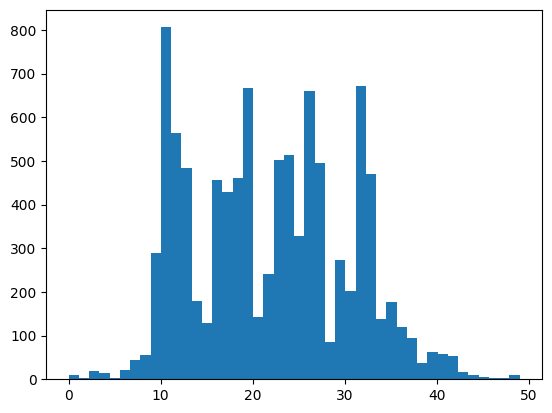

In [57]:
plt.hist(label,bins= "auto")

In [58]:
centers_ascend

tensor([[-2.9256, -2.8981, -2.8427, -2.6020, -2.2857, -2.2371, -2.2019, -1.9746,
         -1.8318, -1.7177, -1.6823, -1.2471, -1.1453, -0.9831, -0.8904, -0.8818,
         -0.8009, -0.5930, -0.5181, -0.2523, -0.1516, -0.1360, -0.0415,  0.0433,
          0.3275,  0.4211,  0.5578,  0.8790,  0.8867,  0.9278,  0.9668,  0.9905,
          1.0669,  1.3203,  1.3312,  1.4268,  1.5274,  1.6300,  1.7194,  1.7718,
          1.8381,  1.9499,  2.2127,  2.4397,  2.6572,  2.7230,  2.7863,  2.7979,
          2.8676,  2.9822]])

In [59]:
centers.min()

tensor(-2.9256)

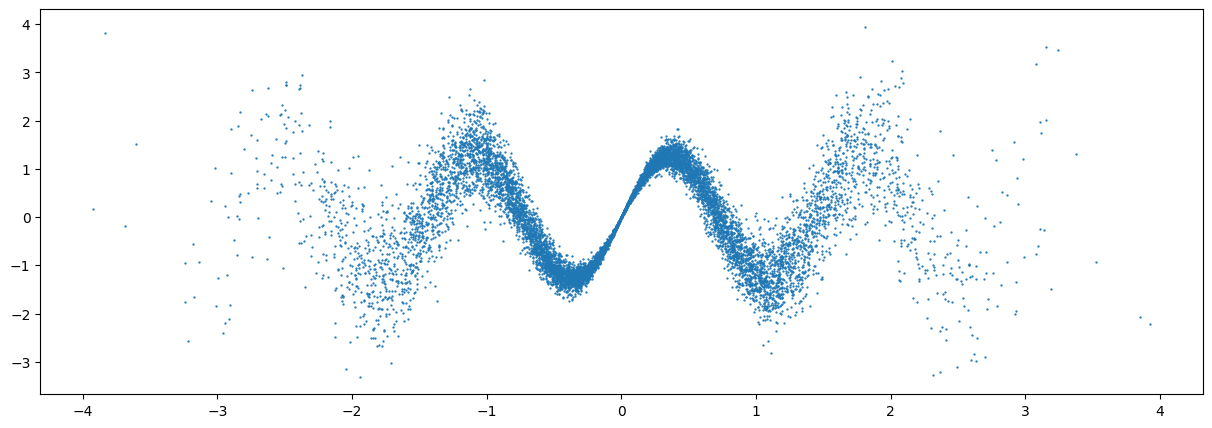

In [60]:
# plot the results

plt.figure(figsize=(15,5))
plt.scatter(train_x_tr.cpu().detach().numpy(), train_y_scalar.cpu().detach().numpy(), s=0.4)

In [61]:
# assign the class labels
centers

Parameter containing:
tensor([[-0.1360, -1.2471,  2.8676,  1.9499,  0.8790, -0.8818,  1.8381, -2.9256,
         -0.8904, -0.1516, -2.2371, -0.5930,  0.9278, -2.2857, -1.9746,  0.4211,
          2.6572,  1.7194,  1.4268,  1.3203, -2.2019,  0.9905, -0.0415, -0.8009,
         -2.6020, -1.6823,  0.8867,  1.5274,  2.2127,  1.0669, -1.7177,  2.9822,
         -0.9831,  2.7979,  0.3275, -1.1453, -2.8981,  2.7863,  2.4397, -2.8427,
          0.5578,  1.6300, -0.5181, -1.8318,  1.3312,  0.0433, -0.2523,  1.7718,
          0.9668,  2.7230]])

In [62]:
train_y_scalar.shape



torch.Size([10000])

(array([  1.,   2.,  18.,  15.,   3.,  22.,  44.,  55.,  45., 244., 806.,
        564., 484., 179., 128., 457., 428., 460., 505., 162., 143., 240.,
        503., 513., 327., 659., 496.,  85., 155., 119., 201., 671., 471.,
        138., 177., 119.,  95.,  38.,  23.,  39.,  59.,  54.,  16.,  10.,
          5.,   2.,   2.,   2.]),
 array([-2.91187000e+00, -2.87039709e+00, -2.72231388e+00, -2.44383478e+00,
        -2.26140118e+00, -2.21948433e+00, -2.08822513e+00, -1.90316796e+00,
        -1.77473509e+00, -1.70001292e+00, -1.46472073e+00, -1.19618905e+00,
        -1.06419659e+00, -9.36780572e-01, -8.86091232e-01, -8.41332912e-01,
        -6.96937084e-01, -5.55534959e-01, -3.85189414e-01, -2.01946616e-01,
        -1.43813610e-01, -8.87397528e-02,  9.18149948e-04,  1.85401440e-01,
         3.74280453e-01,  4.89410758e-01,  7.18377113e-01,  8.82837415e-01,
         9.07250404e-01,  9.47332144e-01,  9.78675127e-01,  1.02871132e+00,
         1.19361734e+00,  1.32577276e+00,  1.37901092e+00,  1.

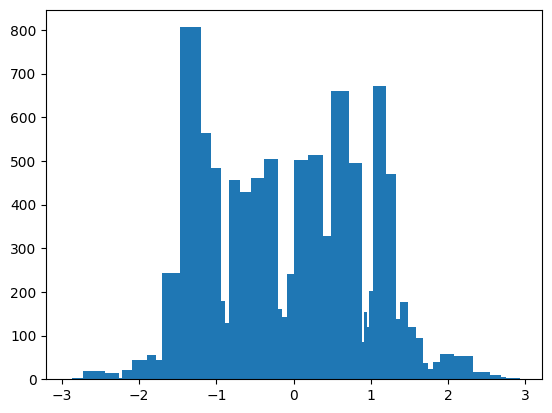

In [63]:
plt.hist(train_y_scalar.cpu().detach().numpy().flatten(), bins=bin_edges.cpu().detach().flatten().numpy())

In [64]:
print(type(features))

<class 'torch.Tensor'>


In [65]:
centers_ascend.roll(1, dims=1)

tensor([[ 2.9822, -2.9256, -2.8981, -2.8427, -2.6020, -2.2857, -2.2371, -2.2019,
         -1.9746, -1.8318, -1.7177, -1.6823, -1.2471, -1.1453, -0.9831, -0.8904,
         -0.8818, -0.8009, -0.5930, -0.5181, -0.2523, -0.1516, -0.1360, -0.0415,
          0.0433,  0.3275,  0.4211,  0.5578,  0.8790,  0.8867,  0.9278,  0.9668,
          0.9905,  1.0669,  1.3203,  1.3312,  1.4268,  1.5274,  1.6300,  1.7194,
          1.7718,  1.8381,  1.9499,  2.2127,  2.4397,  2.6572,  2.7230,  2.7863,
          2.7979,  2.8676]])

In [66]:
centers_ascend

tensor([[-2.9256, -2.8981, -2.8427, -2.6020, -2.2857, -2.2371, -2.2019, -1.9746,
         -1.8318, -1.7177, -1.6823, -1.2471, -1.1453, -0.9831, -0.8904, -0.8818,
         -0.8009, -0.5930, -0.5181, -0.2523, -0.1516, -0.1360, -0.0415,  0.0433,
          0.3275,  0.4211,  0.5578,  0.8790,  0.8867,  0.9278,  0.9668,  0.9905,
          1.0669,  1.3203,  1.3312,  1.4268,  1.5274,  1.6300,  1.7194,  1.7718,
          1.8381,  1.9499,  2.2127,  2.4397,  2.6572,  2.7230,  2.7863,  2.7979,
          2.8676,  2.9822]])

In [67]:
centers

Parameter containing:
tensor([[-0.1360, -1.2471,  2.8676,  1.9499,  0.8790, -0.8818,  1.8381, -2.9256,
         -0.8904, -0.1516, -2.2371, -0.5930,  0.9278, -2.2857, -1.9746,  0.4211,
          2.6572,  1.7194,  1.4268,  1.3203, -2.2019,  0.9905, -0.0415, -0.8009,
         -2.6020, -1.6823,  0.8867,  1.5274,  2.2127,  1.0669, -1.7177,  2.9822,
         -0.9831,  2.7979,  0.3275, -1.1453, -2.8981,  2.7863,  2.4397, -2.8427,
          0.5578,  1.6300, -0.5181, -1.8318,  1.3312,  0.0433, -0.2523,  1.7718,
          0.9668,  2.7230]])

In [68]:

bin_edges = ((centers_ascend + centers_ascend.roll(1, dims=1))/2)[:,1:].flatten().detach()
min_val, max_val = bin_edges.min() - 0.5, bin_edges.max() + 0.5
width = 0.01

x_pred = np.arange(-4,4,width)

intervals = np.array(list(zip([min_val, *bin_edges], [*bin_edges, max_val])))
intervals.shape
bbox_x = x_pred-(width/2)
bbox_y = intervals[:,0]
bbox_w = np.array([width]*intervals.shape[0])
bbox_h = intervals[:,1] - intervals[:,0]

In [69]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

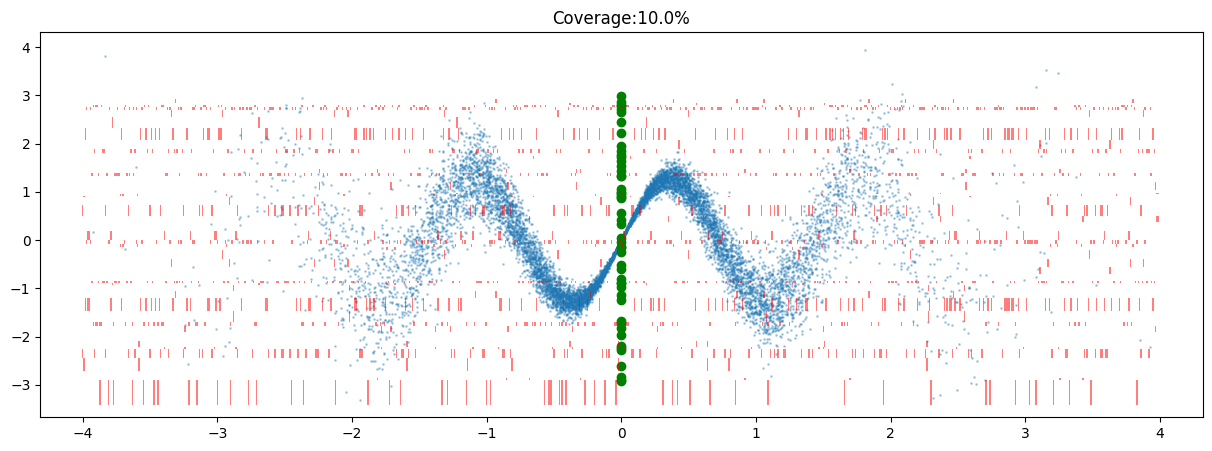

In [71]:
x_pred = torch.from_numpy(np.arange(-4,4,width).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
model.eval()
_, centers,y_pred,_ = model(train_x_tr)
centers = centers.flatten()
probs = y_pred.softmax(dim=1)

sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
sorted_cdf = sorted_pdf.cumsum(dim=1)
tau = 0.1
first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)
# first_nth_indices

pred_boxes = []
for i in range(sorted_indices.shape[0]):
    # print(sorted_indices[i][:first_nth_indices[i]+1])
    prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
    for j in prediction_set:
        if i >= 800:
            break
        xy = (bbox_x[i], bbox_y[j])
        height = bbox_h[j]
        # width = bbox_w[i]
        pred_boxes.append(Rectangle(xy, width, height))


# plt.figure(figsize=(15,5))
fig, ax = plt.subplots(figsize=(15,5))
# Create patch collection with specified colour/alpha
pc = PatchCollection(pred_boxes, facecolor='r', alpha=0.5,
                    edgecolor='none')

# Add collection to axes
ax.set_title(f"Coverage:{tau*100}%")
ax.scatter(train_x, train_y_scalar, s=1, alpha=0.3)
ax.scatter([0] * len(centers.flatten()), centers.flatten().cpu().detach().numpy(), c='g')
ax.add_collection(pc)

In [30]:
centers

tensor([-13.6664,  -3.4842,  -3.4790,  -3.4813,  -3.4823,  -3.4810,  -3.4811,
         -3.4839,  -3.4577,  -3.4520,  -3.4779,  -3.4630,  -3.4711,  -3.4766,
         -3.4833,  -3.1980,  -3.0978,  -3.2574,  -3.2089,  -3.2928,  -3.1708,
         -3.1590,  -3.1499,  -2.9506,  -2.6974,  -2.1485,  -1.1377,  -0.3000,
          0.4039,   1.1873,   2.2316,   2.6901,   2.9465,   3.1336,   3.2330,
          3.2000,   3.3225,   3.3283,   3.3413,   3.3285,   3.3422,   3.3377,
          3.3307,   3.3425,   3.3404,   3.3415,   3.3428,   3.3408,  14.7891,
          3.3426], grad_fn=<ViewBackward0>)

In [230]:
train_y_scalar.max()

tensor(3.9432)

In [231]:
# Prediction for x=0
zero_preds = model(torch.tensor([3]).reshape([-1,1]).float().to(device)).softmax(dim=1)
# zero_preds.sort(descending=True, dim=1)
zero_preds_np = zero_preds.detach().cpu().numpy()
plt.title("P(Y|X=3)")
plt.bar(np.arange(zero_preds_np.shape[1]), height=zero_preds_np.reshape([-1]))

AttributeError: 'tuple' object has no attribute 'softmax'

In [232]:
np.digitize(0, bin_edges) # Get the class of each point using histogram bins

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [119]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
class QRegressor(torch.nn.Module):
    def __init__(self, in_size=1, out_size=1):
        super(QRegressor,self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, 3*self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [120]:
def PinballLoss(input, target):
    ## Other Losses
    # Normal loss
    #loss = (((input[0] - target)/torch.exp(input[1]))**2+input[1]).mean()
    # Laplace loss
    #loss = (torch.abs((input[0] - target)/torch.exp(input[1]))+input[1]).mean()
    # t-distribution loss
    #nu = 3
    #loss = ((nu + 1)/2*torch.log(1+((input[0] - target)/torch.exp(input[1]))**2/nu)+input[1]).mean()
    # print(input, target)

    ## Quantile Loss
    q1 = 0.05
    q2 = 0.5
    q3 = 0.95


    ## Keras quantile loss, https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/
    #e = y_p-y
    #return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

    ## Quantile Loss
    ## for q1, q2, q3
    #print(input.shape)
    #print(input[:,0:1].shape)
    #print(target.shape)
    e1 = input[:,0:1] - target # !!! if input[:,0]  -> shape = (1000,)
    e2 = input[:,1:2] - target
    e3 = input[:,2:3] - target
    eq1 = torch.max(q1*e1, (q1-1)*e1)
    eq2 = torch.max(q2*e2, (q2-1)*e2)
    eq3 = torch.max(q3*e3, (q3-1)*e3)

    #eq1 = torch.max(0.05*e1, (0.05-1)*e1)
    #eq2 = torch.max(0.5*e2, (0.5-1)*e2)
    #eq3 = torch.max(0.95*e3, (0.95-1)*e3)

    loss = (eq1 + eq2 + eq3).mean()

    return loss

In [121]:
train_y_tr.shape

torch.Size([10000, 47])

In [122]:
train_x_tr = train_x_tr.to(device)
train_y_scalar = train_y_scalar.to(device)

model = QRegressor().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [123]:
for step in range(3000):
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    yqs = model(train_x_tr)
    loss = PinballLoss(input=yqs, target =train_y_scalar)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1000 loss=0.2111
epoch 2000 loss=0.2094
epoch 3000 loss=0.2084


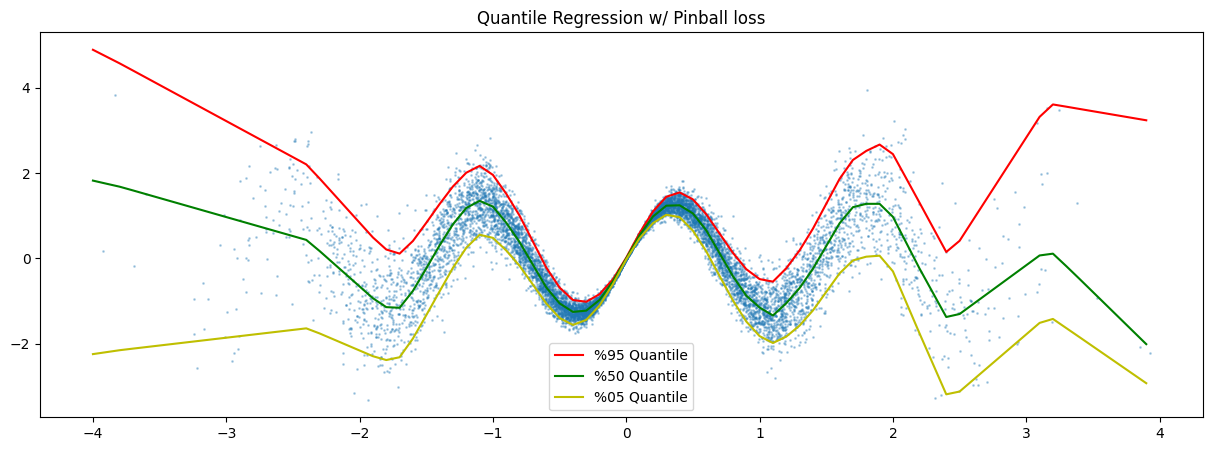

In [124]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = model(x_pred.to(device))

plt.figure(figsize=(15,5))

plt.title("Quantile Regression w/ Pinball loss")
plt.scatter(train_x, train_y, s=1, alpha=0.3)

plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,0], c='r', label="%95 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,1], c='g', label="%50 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,2], c='y', label="%05 Quantile")
plt.legend()

plt.show()

In [125]:
y_pred

tensor([[ 4.8884e+00,  1.8233e+00, -2.2418e+00],
        [ 4.7294e+00,  1.7515e+00, -2.1962e+00],
        [ 4.5705e+00,  1.6808e+00, -2.1506e+00],
        [ 4.4023e+00,  1.5934e+00, -2.1132e+00],
        [ 4.2332e+00,  1.5042e+00, -2.0767e+00],
        [ 4.0640e+00,  1.4151e+00, -2.0401e+00],
        [ 3.8948e+00,  1.3259e+00, -2.0036e+00],
        [ 3.7257e+00,  1.2367e+00, -1.9671e+00],
        [ 3.5565e+00,  1.1475e+00, -1.9306e+00],
        [ 3.3873e+00,  1.0583e+00, -1.8940e+00],
        [ 3.2182e+00,  9.6917e-01, -1.8575e+00],
        [ 3.0490e+00,  8.7999e-01, -1.8210e+00],
        [ 2.8798e+00,  7.9081e-01, -1.7845e+00],
        [ 2.7106e+00,  7.0163e-01, -1.7479e+00],
        [ 2.5415e+00,  6.1244e-01, -1.7114e+00],
        [ 2.3723e+00,  5.2326e-01, -1.6749e+00],
        [ 2.2031e+00,  4.3409e-01, -1.6384e+00],
        [ 1.8726e+00,  1.7332e-01, -1.7574e+00],
        [ 1.5272e+00, -1.0323e-01, -1.8908e+00],
        [ 1.1818e+00, -3.7977e-01, -2.0242e+00],
        [ 8.3636e-01

In [42]:
train_y

array([-0.43496885, -1.24701221, -1.01193887, ...,  0.72884625,
        1.41644938,  1.21039448])